# Intro

Now that the audio data and metadata has been wrangled into the Python environment and explored, it's time for preprocessing and modeling.

# Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Preprocessing

Truthfully, much of the preprocessing for this dataset occured during data ingestion. The labels are just strings in array `all_labels`, and labels are mapped to their indices in the function `get_spectrogram_and_label_id()`. The TensorFlow function `tensorflow.audio.decode_wav()` scaled the audio data between -1.0 and 1.0 before converting the signal to a spectrogram through the absolute value of a Short-Time Fourier Transform. All of that is repeated in the cell below, with two new functions for error checking and test data ingestion called out by comments.

In [2]:
path_to_train_metadata = 'FSDKaggle2018.meta/train_post_competition.csv'
path_to_train_files = 'FSDKaggle2018.audio_train.nosync'
train_metadata = pd.read_csv(path_to_train_metadata)
train_files = os.listdir(path=path_to_train_files)

path_to_test_metadata = 'FSDKaggle2018.meta/test_post_competition_scoring_clips.csv'
path_to_test_files = 'FSDKaggle2018.audio_test.nosync'
test_metadata = pd.read_csv(path_to_test_metadata)
test_files = os.listdir(path=path_to_test_files)

all_files = pd.Series(train_files + test_files).sort_values().reset_index(drop=True)
file_count = len(all_files)
file_name_unique = all_files.nunique()
assert file_count == file_name_unique

# NEW: confirms each metadate file name corresponds to a real file
all_metadata_files = pd.concat([train_metadata.fname, test_metadata.fname]).sort_values().reset_index(drop=True)
assert sum(all_metadata_files == all_files) == file_count

all_labels = test_metadata.label.unique()

training_files_with_labels = list(zip(train_metadata.fname, train_metadata.label))
testing_files_with_labels = list(zip(test_metadata.fname, test_metadata.label))

cutoff_in_seconds = 4

AUTOTUNE = tf.data.AUTOTUNE

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label_train(labeled_file):
    audio_binary = tf.io.read_file(path_to_train_files + '/' + labeled_file[0])
    waveform = decode_audio(audio_binary)
    return waveform, labeled_file[1]

# NEW: added for create the test Dataset
def get_waveform_and_label_test(labeled_file):
    audio_binary = tf.io.read_file(path_to_test_files + '/' + labeled_file[0])
    waveform = decode_audio(audio_binary)
    return waveform, labeled_file[1]

def get_spectrogram(waveform):
    input_len = int(44.1*1000*cutoff_in_seconds)
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([input_len] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=555, frame_step=343)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == all_labels)
    return spectrogram, label_id

A preprocessing pipeline can be established to using the defined functions to prepare data for modeling.

In [3]:
def preprocess_dataset_train(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label_train, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [4]:
def preprocess_dataset_test(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label_test, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

A validation set must be created from the training set.

In [5]:
training_files_with_labels = tf.random.shuffle(training_files_with_labels)
validation_files_with_labels = training_files_with_labels[int(len(training_files_with_labels)*0.9):]
training_files_with_labels = training_files_with_labels[:int(len(training_files_with_labels)*0.9)]
testing_files_with_labels = tf.random.shuffle(testing_files_with_labels)

Metal device set to: Apple M1 Max


2022-03-12 13:31:26.654245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-12 13:31:26.654383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The training files are preprocessed, importantly outside the preprocessing pipeline to retain access to raw spectrograms and information about the shape will be necessary to normalize the data and create the CNN.

In [6]:
labeled_training_files_ds = tf.data.Dataset.from_tensor_slices(training_files_with_labels)
training_waveform_ds = labeled_training_files_ds.map(map_func=get_waveform_and_label_train, num_parallel_calls=AUTOTUNE)
training_spectrogram_ds = training_waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Create the train, validation, and test Datasets.

In [7]:
train_ds = training_spectrogram_ds
val_ds = preprocess_dataset_train(validation_files_with_labels)
test_ds = preprocess_dataset_test(testing_files_with_labels)

Set a batch size for running the training.

In [8]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [9]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [10]:
for spectrogram, _ in training_spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(all_labels)

Input shape: (513, 513, 1)


2022-03-12 13:31:26.885667: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Modeling

The final stage of preprocessing, and the beginning of modeling, is creating the CNN. Importantly, a normalization layer is fit to the training spectrograms. Then, the model is created with many layers of downsampling: resizing, convolution, pooling, and dropouts. All of these help to pick out key features and allow the model to train faster.

In [11]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=training_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input
    layers.Resizing(256, 256),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

2022-03-12 13:31:27.033864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 13:31:27.111477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 1)       0         
                                                                 
 normalization (Normalizatio  (None, 256, 256, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [13]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2022-03-12 13:31:50.746567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - ETA: 0s - loss: 3.7993 - accuracy: 0.1026

2022-03-12 13:33:22.423791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 100s 740ms/step - loss: 3.7993 - accuracy: 0.1026 - val_loss: 3.1172 - val_accuracy: 0.2405
Epoch 2/10
134/134 [==============================] - 104s 772ms/step - loss: 2.7850 - accuracy: 0.2780 - val_loss: 2.5433 - val_accuracy: 0.3397
Epoch 3/10
134/134 [==============================] - 104s 770ms/step - loss: 1.7811 - accuracy: 0.5192 - val_loss: 2.3198 - val_accuracy: 0.4072
Epoch 4/10
134/134 [==============================] - 104s 771ms/step - loss: 1.1418 - accuracy: 0.7042 - val_loss: 2.4297 - val_accuracy: 0.4378
Epoch 5/10
134/134 [==============================] - 104s 771ms/step - loss: 0.7487 - accuracy: 0.8239 - val_loss: 2.5175 - val_accuracy: 0.4536
Epoch 5: early stopping


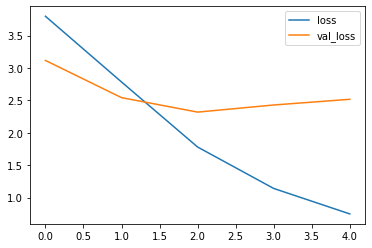

In [14]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.savefig('img/loss.png')
plt.show()

The fitting stopped early as the model identified that validation loss was no longer decreasing, and the tendency of the neural networks to overfit can be seen by the continued decrease in training loss without any validation gain.

With the model in hand, the test set can be explored.

In [15]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [16]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

2022-03-12 13:40:28.943052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test set accuracy: 52%


The model achieved 52% accuracy on the test set, which is not bad considering randomly assigning 1 out of 41 labels would be about 2.5% accuracy (which is a safe quick assumption since the test set looked more or less evenly distributed during EDA). However, there is still significant room for improvement. A confusion matrix can help understand what the model is getting wrong.

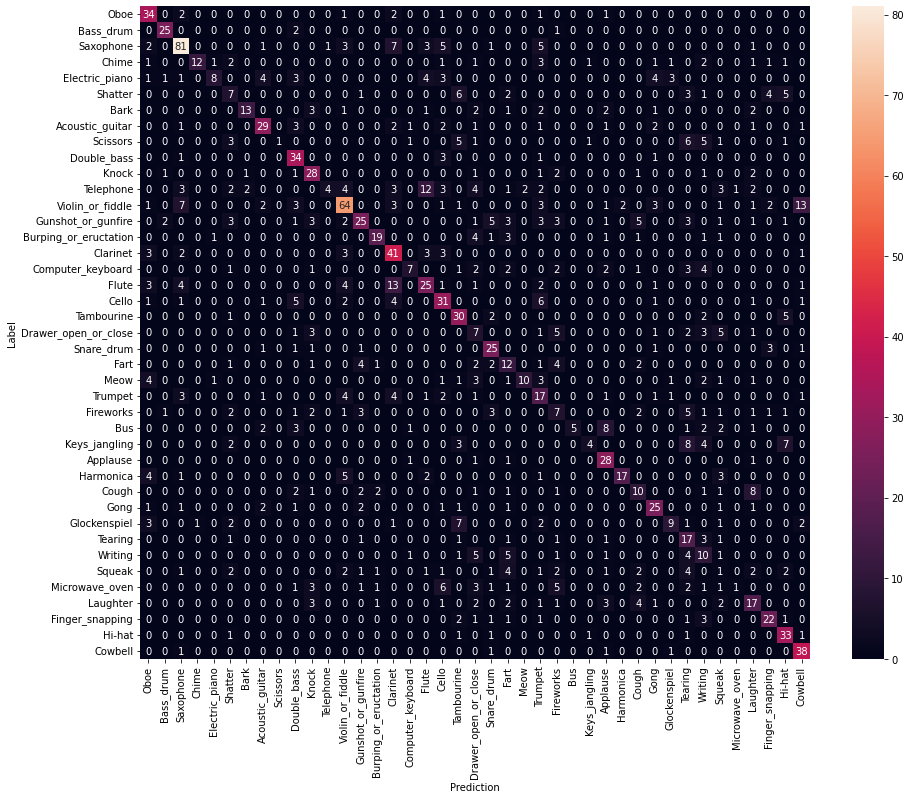

In [17]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_mtx, xticklabels=all_labels, yticklabels=all_labels, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('img/confusion.png')
plt.show()

Not bad! A diagonal line is clearly observed, meaning that a lot of predictions are matching the labels. Where there are mistakes, they are easy to understand: a cello being predicted as a double bass, a shatter as a tambourine, etc. Gunshots are being mistaken for farts, which is genuinely hilarious. And certain things are not predicted well at all, like a microwave oven, but these often entail many types of sounds like chiming, slamming, whirring, etc, so it's easy to see this sound as hard to nail down.

Most interestingly, and maybe due to the high ratio of verified sound files, saxophones are predicted quite well. Well, the author of this project owns a saxophone, so let's see how the model does.

![generating](img/saxophone.jpg)

In [18]:
new_audio_fnames = pd.Series('C.wav')
new_audio_labels = pd.Series('Saxophone')
path_to_new_files = 'audio'

new_files_with_labels = list(zip(new_audio_fnames, new_audio_labels))
new_files_with_labels

[('C.wav', 'Saxophone')]

In [19]:
def get_waveform_and_label_new(labeled_file):
    audio_binary = tf.io.read_file(path_to_new_files + '/' + labeled_file[0])
    waveform = decode_audio(audio_binary)
    return waveform, labeled_file[1]

def preprocess_dataset_new(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label_new, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [20]:
new_waveform, _ = get_waveform_and_label_new(new_files_with_labels[0])
display.display(display.Audio(new_waveform, rate=44100))

In [21]:
new_ds = preprocess_dataset_new(new_files_with_labels)

In [22]:
new_audio = []
new_labels = []

for audio, label in new_ds:
    new_audio.append(audio.numpy())
    new_labels.append(label.numpy())

new_audio = np.array(new_audio)
new_labels = np.array(new_labels)

In [23]:
new_pred = np.argmax(model.predict(new_audio), axis=1)

2022-03-12 13:40:56.659367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [24]:
all_labels[new_pred]

array(['Saxophone'], dtype=object)

It works!! Awesome.